Running IMPROVED temporal change detection...
Found 384 total patches
Found 16 unique locations
Adaptive thresholds:
  - Mining threshold (70th percentile): 0.3200
  - High-confidence threshold (90th percentile): 0.3455
  - Score range: [0.2622, 0.3726]

FINAL LABEL DISTRIBUTION:
MINING patches: 65
NON-MINING patches: 319
Total patches: 384
Mining ratio: 16.9%


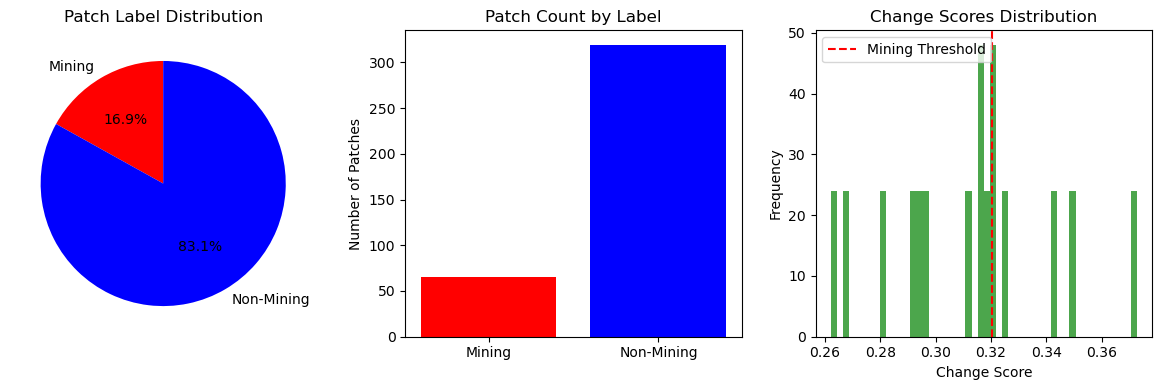

Labels saved to: ../data/annotations/improved_labels.json

Ready for model training with 384 patches (65 mining)


In [5]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

class NumpyEncoder(json.JSONEncoder):
    """Custom encoder for NumPy data types"""
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                          np.int16, np.int32, np.int64, np.uint8,
                          np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
                            np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Setup paths
PATCHES_DIR = "../data/processed/patches_all"
os.makedirs("../data/annotations", exist_ok=True)

def load_all_patches(patches_dir):
    """Load all patches from all subdirectories"""
    all_patches = []
    
    for root, dirs, files in os.walk(patches_dir):
        for file in files:
            if file.endswith('.npy') and 'patch_' in file:
                full_path = os.path.join(root, file)
                all_patches.append(full_path)
    
    print(f"Found {len(all_patches)} total patches")
    return all_patches

def improved_temporal_change_detection(all_patches):
    """Better change detection with adaptive thresholding"""
    location_groups = defaultdict(list)
    
    for patch_path in all_patches:
        path_parts = Path(patch_path).parts
        image_name = path_parts[-2]
        patch_file = path_parts[-1]
        
        coords = patch_file.replace('patch_', '').replace('.npy', '').split('_')
        if len(coords) == 2:
            location_key = f"{coords[0]}_{coords[1]}"
            location_groups[location_key].append((image_name, patch_path))
    
    print(f"Found {len(location_groups)} unique locations")
    
    labels = {}
    all_change_scores = []
    
    for location, patches in location_groups.items():
        patches.sort(key=lambda x: x[0])
        
        if len(patches) >= 2:
            try:
                first_patch = np.load(patches[0][1])
                last_patch = np.load(patches[-1][1])
                
                # Calculate multiple change metrics
                ndwi_diff = np.abs(last_patch[4] - first_patch[4])
                mndwi_diff = np.abs(last_patch[5] - first_patch[5])
                
                # More sophisticated change detection
                change_metrics = {
                    'mean_ndwi_change': float(np.mean(ndwi_diff)),
                    'max_ndwi_change': float(np.max(ndwi_diff)),
                    'ndwi_variance': float(np.var(ndwi_diff)),
                    'water_area_change': float(calculate_water_area_change(first_patch[4], last_patch[4])),
                }
                
                # Weighted change score
                change_score = (
                    change_metrics['mean_ndwi_change'] * 0.4 +
                    change_metrics['max_ndwi_change'] * 0.3 +
                    change_metrics['water_area_change'] * 0.3
                )
                
                all_change_scores.append(change_score)
                
                # Store score for adaptive thresholding
                for image_name, patch_path in patches:
                    patch_filename = f"{image_name}/{os.path.basename(patch_path)}"
                    labels[patch_filename] = {
                        'label': None,  # Will be set after threshold calculation
                        'change_score': float(change_score),
                        'metrics': change_metrics
                    }
                    
            except Exception as e:
                print(f"Error processing location {location}: {e}")
                for image_name, patch_path in patches:
                    patch_filename = f"{image_name}/{os.path.basename(patch_path)}"
                    labels[patch_filename] = {'label': 0, 'change_score': 0.0, 'metrics': {}}
        else:
            # Single patch - conservative approach
            try:
                patch_data = np.load(patches[0][1])
                ndwi_variance = float(np.var(patch_data[4]))
                patch_filename = f"{patches[0][0]}/{os.path.basename(patches[0][1])}"
                labels[patch_filename] = {
                    'label': 0,  # Default to non-mining for single patches
                    'change_score': ndwi_variance,
                    'metrics': {'ndwi_variance': ndwi_variance}
                }
            except:
                patch_filename = f"{patches[0][0]}/{os.path.basename(patches[0][1])}"
                labels[patch_filename] = {'label': 0, 'change_score': 0.0, 'metrics': {}}
    
    # ADAPTIVE THRESHOLDING - Key fix for over-labeling
    if all_change_scores:
        change_scores_array = np.array(all_change_scores)
        
        # Use percentiles for balanced labeling
        threshold_low = np.percentile(change_scores_array, 70)   # Top 30% are mining
        threshold_high = np.percentile(change_scores_array, 90)  # Top 10% are high-confidence mining
        
        print(f"Adaptive thresholds:")
        print(f"  - Mining threshold (70th percentile): {threshold_low:.4f}")
        print(f"  - High-confidence threshold (90th percentile): {threshold_high:.4f}")
        print(f"  - Score range: [{np.min(change_scores_array):.4f}, {np.max(change_scores_array):.4f}]")
        
        # Apply adaptive labeling
        mining_count = 0
        for patch_info in labels.values():
            if 'change_score' in patch_info and patch_info['change_score'] > 0:
                if patch_info['change_score'] >= threshold_high:
                    patch_info['label'] = 1  # High-confidence mining
                    mining_count += 1
                elif patch_info['change_score'] >= threshold_low:
                    # Random sampling for medium-confidence patches to balance dataset
                    if np.random.random() < 0.3:  # Only label 30% as mining
                        patch_info['label'] = 1
                        mining_count += 1
                    else:
                        patch_info['label'] = 0
                else:
                    patch_info['label'] = 0
    
    return labels

def calculate_water_area_change(ndwi1, ndwi2):
    """Calculate change in water area based on NDWI threshold"""
    water_threshold = 0.0  # NDWI > 0 indicates water
    
    water_pixels1 = np.sum(ndwi1 > water_threshold)
    water_pixels2 = np.sum(ndwi2 > water_threshold)
    
    total_pixels = ndwi1.size
    water_change = abs(water_pixels2 - water_pixels1) / total_pixels
    
    return water_change

def analyze_and_save_results(labels):
    """Analyze labeling results and save with proper encoding"""
    # Extract final labels for analysis
    final_labels = {k: v['label'] for k, v in labels.items() if 'label' in v}
    mining_count = sum(final_labels.values())
    total_count = len(final_labels)
    
    print(f"\nFINAL LABEL DISTRIBUTION:")
    print(f"MINING patches: {mining_count}")
    print(f"NON-MINING patches: {total_count - mining_count}")
    print(f"Total patches: {total_count}")
    print(f"Mining ratio: {mining_count/total_count*100:.1f}%")
    
    # Plot distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    counts = [mining_count, total_count - mining_count]
    labels_pie = ['Mining', 'Non-Mining']
    plt.pie(counts, labels=labels_pie, autopct='%1.1f%%', startangle=90, colors=['red', 'blue'])
    plt.title('Patch Label Distribution')
    
    plt.subplot(1, 3, 2)
    plt.bar(labels_pie, counts, color=['red', 'blue'])
    plt.title('Patch Count by Label')
    plt.ylabel('Number of Patches')
    
    # Plot change scores distribution
    plt.subplot(1, 3, 3)
    change_scores = [v.get('change_score', 0) for v in labels.values()]
    plt.hist(change_scores, bins=50, alpha=0.7, color='green')
    plt.axvline(x=np.percentile(change_scores, 70), color='red', linestyle='--', label='Mining Threshold')
    plt.xlabel('Change Score')
    plt.ylabel('Frequency')
    plt.title('Change Scores Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Save with proper encoding
    labels_file = "../data/annotations/improved_labels.json"
    with open(labels_file, 'w') as f:
        json.dump(labels, f, indent=2, cls=NumpyEncoder)
    
    print(f"Labels saved to: {labels_file}")
    
    return final_labels, mining_count, total_count

# Execute improved labeling
print("Running IMPROVED temporal change detection...")
all_patches = load_all_patches(PATCHES_DIR)
labels = improved_temporal_change_detection(all_patches)

# Analyze and save results
final_labels, mining_count, total_count = analyze_and_save_results(labels)

print(f"\nReady for model training with {total_count} patches ({mining_count} mining)")